In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Magazine_data = pd.read_csv('/content/Magazine_Subscriptions_5.csv')

In [ ]:
Magazine_data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style/Format:,image/0,image/1
0,4,True,"02 26, 2014",A5QQOOZJOVPSF,B00005N7P0,John L. Mehlmauer,"I'm old, and so is my computer. Any advice th...",Cheapskates guide,1393372800,NaN,NaN,NaN,NaN
1,5,False,"03 6, 2004",A5RHZE7B8SV5Q,B00005N7PS,gorillazfan249,"There's nothing to say, but if you want a REAL...",The best mature Men's magazine.,1078531200,3.0,NaN,NaN,NaN
2,1,False,"07 15, 2003",A1RPTVW5VEOSI,B00005N7PS,Michael J. Edelman,If you're the kind of man who looks at himself...,THE Magazine for the Self-Centered Male,1058227200,17.0,NaN,NaN,NaN
3,1,True,"01 31, 2015",A1SFRBCMW8XVBW,B00005N7PS,Hoyett L. Barnett,Nothing to it. Just an advertisement. Little...,Nothing to it. Just an advertisement. Little a...,1422662400,NaN,NaN,NaN,NaN
4,5,True,"10 5, 2010",A1IU9VPCBKZPE8,B00005N7P0,Randolph Eck,When PC Magazine ceased publication of their p...,Excellent Computer Magazine,1286236800,2.0,NaN,NaN,NaN


For the purposes of this project we will only be needing the user id, the item id and the rating so we drop all other columns

In [ ]:
Magazine_data = Magazine_data[['reviewerID', 'asin', 'overall']]

In [ ]:
Magazine_data.columns=['userId', 'productId', 'Rating']
Magazine_data.head()

,userId,productId,Rating
0,A5QQOOZJOVPSF,B00005N7P0,4
1,A5RHZE7B8SV5Q,B00005N7PS,5
2,A1RPTVW5VEOSI,B00005N7PS,1
3,A1SFRBCMW8XVBW,B00005N7PS,1
4,A1IU9VPCBKZPE8,B00005N7P0,5


In [ ]:
Magazine_data.shape

(2375, 3)

We make sure that each column is of the right type

In [ ]:
Magazine_data.dtypes

userId       object
productId    object
Rating        int64
dtype: object

We make sure there are no non null objects

In [ ]:
print('Number of missing values across columns: \n',Magazine_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
dtype: int64


In [ ]:
Magazine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     2375 non-null   object
 1   productId  2375 non-null   object
 2   Rating     2375 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 55.8+ KB


In [ ]:
Magazine_data.describe()['Rating'].T


count    2375.00000
mean        4.32000
std         1.11034
min         1.00000
25%         4.00000
50%         5.00000
75%         5.00000
max         5.00000
Name: Rating, dtype: float64

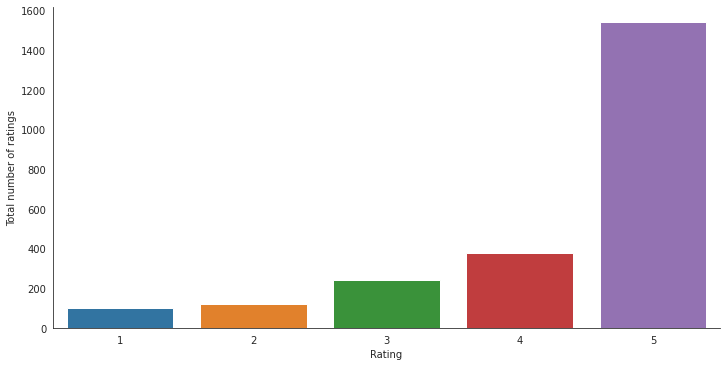

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=Magazine_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",Magazine_data.shape[0])
print("Total No of Users   :", len(np.unique(Magazine_data.userId)))
print("Total No of products  :", len(np.unique(Magazine_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 2375
Total No of Users   : 348
Total No of products  : 157


In [ ]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = Magazine_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A3JPFWKS83R49V    30
A2OTUWUSH49XIN    20
AA14AMM03HMXW     19
AVF9FV7AMRP5C     19
A3GA09FYFKL4EY    19
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe()


<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

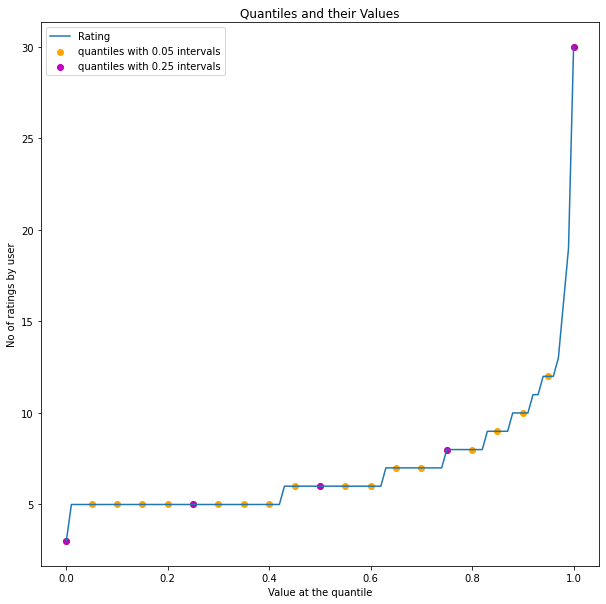

In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 10 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 10)) )



 No of rated product more than 10 per user : 42



In [ ]:
#Getting the new dataframe which contains users who has given 2 or more ratings

new_df=Magazine_data.groupby("productId").filter(lambda x:x['Rating'].count() >=2)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

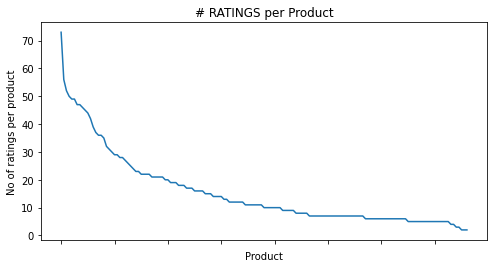

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [ ]:
#Average rating of the product 

new_df.groupby('productId')['Rating'].mean().head()

productId
B00005N7OV    4.535714
B00005N7P0    4.000000
B00005N7PG    4.285714
B00005N7PH    4.750000
B00005N7PN    4.560000
Name: Rating, dtype: float64

In [ ]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B00006LL1D    5.0
B00007AXX1    5.0
B000NY15YI    5.0
B00005NIOZ    5.0
B000FTJ7BE    5.0
Name: Rating, dtype: float64

In [ ]:
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B00005N7QG    73
B00005N7OV    56
B000ILY9LW    52
B00005N7PN    50
B01CF3ECNK    49
Name: Rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [ ]:
ratings_mean_count.head()


,Rating,rating_counts
productId,,
B00005N7OV,4.535714,56
B00005N7P0,4.000000,6
B00005N7PG,4.285714,7
B00005N7PH,4.750000,12
B00005N7PN,4.560000,50


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

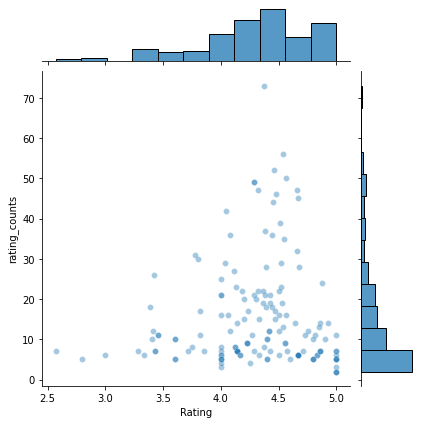

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [ ]:
import pandas_profiling

In [ ]:
new_df.head()

#Creating a sparse matrix for MF


In [ ]:

ratings_matrix = new_df.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

In [ ]:
#Outputting the sparse matrix

ratings_matrix.to_excel('RatingsMatrix.xlsx')

#Model Based MF

In [ ]:
ModelMatrix = ratings_matrix.T
ModelMatrix.head()

In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(ModelMatrix)
decomposed_matrix.shape

(153, 10)

In [ ]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(153, 153)

In [ ]:
ModelMatrix.index[75]

'B00006LKH1'

In [ ]:
i = ModelMatrix.index[75]
product_names = list(ModelMatrix.index)
product_ID = product_names.index(i)
product_ID

75

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

In [ ]:
Recommend = list(ModelMatrix.index[correlation_product_ID > 0.65])
Recommend.remove(i) 

In [ ]:
#25 TOP RECOMENDATIONS
Recommend[0:24]

#Using Hybrid MF

In [ ]:
!pip install lightfm
!pip install scikit-optimize

In [ ]:
import lightfm
from skopt import forest_minimize
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split


In [ ]:
csrRatings = csr_matrix(ratings_matrix.values)
x_train, x_test = lightfm.cross_validation.random_train_test_split(csrRatings, test_percentage=0.2)

In [ ]:

model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.01,
                no_components=150,
                user_alpha=0.000005)

model = model.fit(x_train,
                  epochs=1000, verbose=True)

Epoch: 100%|██████████| 1000/1000 [00:10<00:00, 94.35it/s]


In [ ]:
auc=lightfm.evaluation.auc_score(model, x_test, num_threads=2)

In [ ]:
auc.mean()

0.717641